In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import coint
from scipy import stats
import scipy
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import math
%matplotlib inline

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

In [3]:
Tickers = list(df[0].Symbol)

In [4]:
import quandl
quandl.ApiConfig.api_key = 'ZtrVMzQmPvx8zec1J4r9'

start = '2015-12-31'
end = '2017-12-31'

In [5]:
def get_price(symbol):
    data = quandl.get_table('WIKI/PRICES', ticker = symbol, 
                        qopts = { 'columns': ['Date','adj_close'] }, 
                        date = { 'gte': start, 'lte': end }, 
                        paginate=True)
    return data.set_index('date')

In [6]:
data = get_price('TSLA')

In [7]:
SP500 = pd.read_csv('S&P.csv') 

In [8]:
SP500 = SP500[['Date', 'Adj Close']].set_index('Date')

In [9]:
SP500.columns = ['adj_close']

In [10]:
BenchMark = SP500[(SP500.index > start) & (SP500.index < end)]
Asset = data['adj_close']

In [11]:
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.742
Date:                Mon, 24 Jun 2019   Prob (F-statistic):             0.0299
Time:                        21:37:50   Log-Likelihood:                 1170.5
No. Observations:                 502   AIC:                            -2337.
Df Residuals:                     500   BIC:                            -2329.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.425      0.671      -0.003       0.002
x1             0.3516      0.161      2.178      0.030       0.034       0.669
==============================================================================
Omnibus:                       53.629   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.499
Skew:                           0.575   Prob(JB):                     1.52e-27
Kurtosis:                       5.140   Cond. No.                         154.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

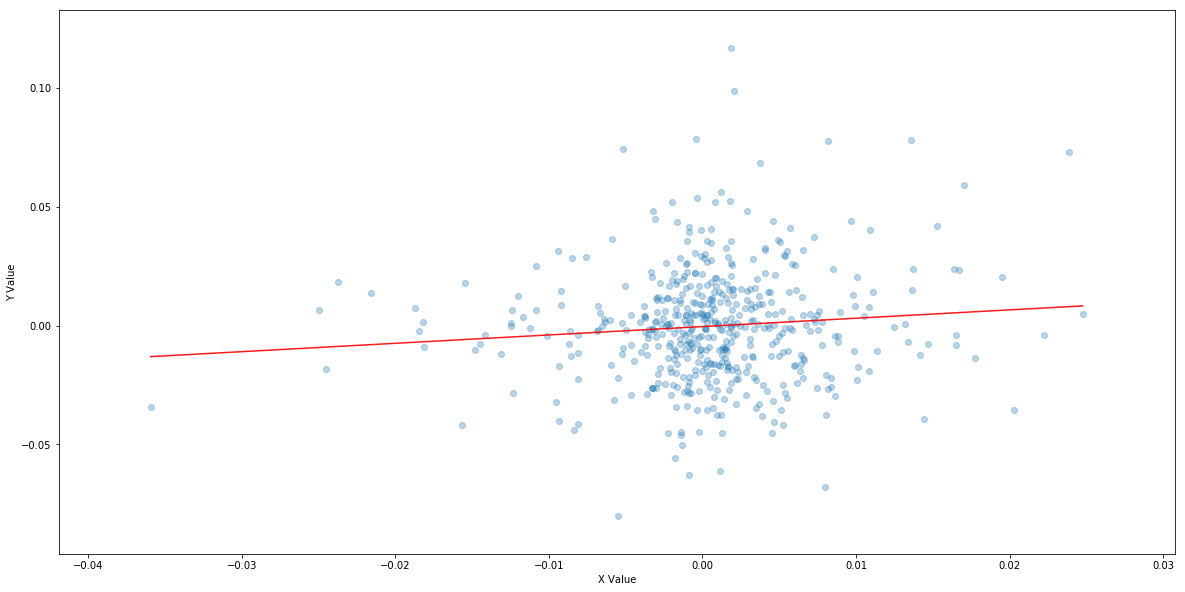

In [12]:
# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = Asset.pct_change()[1:]
r_b = BenchMark.pct_change()[1:]

linreg(r_b.values, r_a.values)

**MLE for Asset Returns**

In [13]:
absolute_returns = np.diff(Asset)
# This will give us the percentage return over the last day's value
# the [:-1] notation gives us all but the last item in the array
# We do this because there are no returns on the final price in the array.
returns = absolute_returns/Asset[:-1]

C:\Anaconda3\envs\TFMagic\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


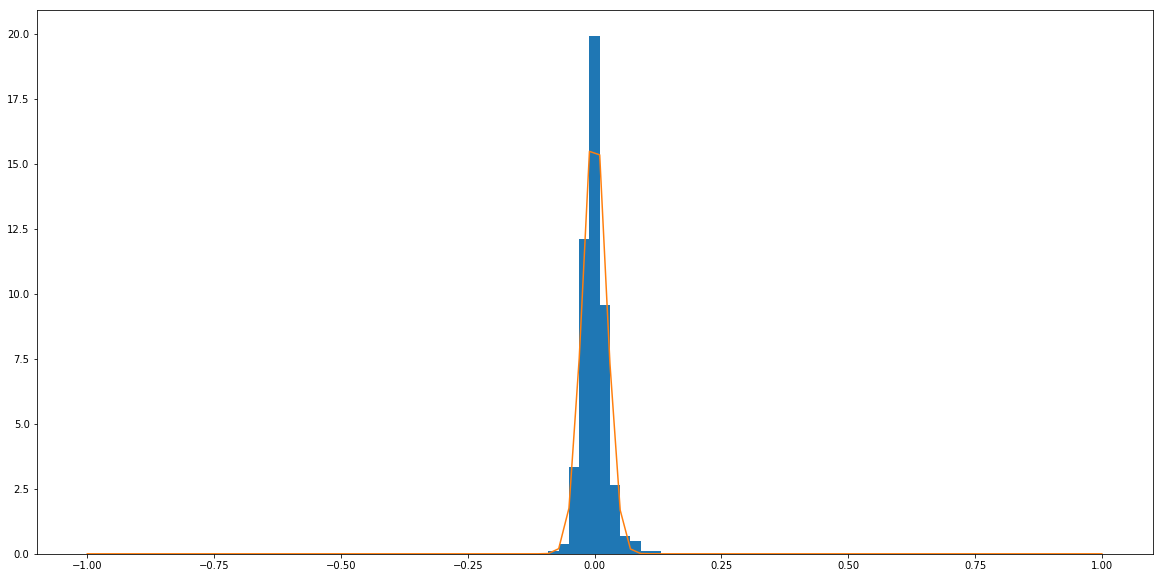

In [14]:
mu, std = scipy.stats.norm.fit(returns)
pdf = scipy.stats.norm.pdf
x = np.linspace(-1,1, num=100)
fig, ax = plt.subplots(figsize=(20, 10))
h = plt.hist(returns, bins=x, normed='true')
l = plt.plot(x, pdf(x, loc=mu, scale=std))

In [15]:
from statsmodels.stats.stattools import jarque_bera
jarque_bera(returns)

(138.69658386856443,
 7.628154550910181e-31,
 0.6202793442411362,
 5.256529750882423)

In [16]:
jarque_bera(np.random.normal(0, 1, 100))

(0.9136120322571515,
 0.6333031787504118,
 0.07714361440799289,
 2.5578887710473754)

In [17]:
# Load pricing data for two arbitrarily-chosen assets and SPY
Asset1 = get_price('MSFT')
Asset2 = get_price('TSLA')
Benchmark = BenchMark

In [18]:
Benchmark.head()

,adj_close
Date,
2016-01-04,2012.660034
2016-01-05,2016.709961
2016-01-06,1990.260010
2016-01-07,1943.089966
2016-01-08,1922.030029


In [19]:
# First, run a linear regression on the two assets
slr = regression.linear_model.OLS(Asset1, sm.add_constant(Asset2)).fit()
print ('SLR beta of asset2:', slr.params[1])

SLR beta of asset2: 0.1432196627867425


C:\Anaconda3\envs\TFMagic\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [20]:
# Run multiple linear regression using Asset2 and SPY as independent variables
mlr = regression.linear_model.OLS(Asset1, sm.add_constant(np.column_stack((Asset2, Benchmark)))).fit()

prediction = mlr.params[0] + mlr.params[1]*Asset2 + mlr.params[2]*Benchmark
prediction.name = 'Prediction'

print('MLR beta of asset2:', mlr.params[1], '\nMLR beta of S&P 500:', mlr.params[2])

MLR beta of asset2: 0.03648857628809983 
MLR beta of S&P 500: -0.04050530791111122


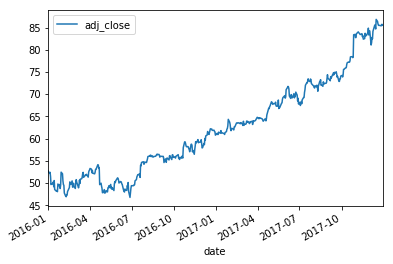

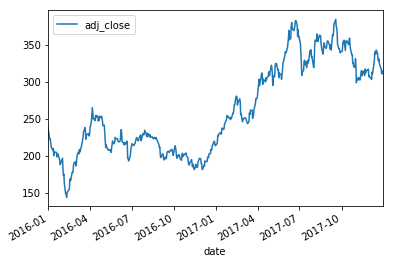

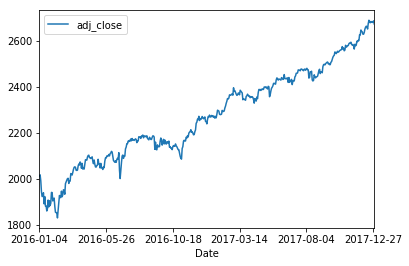

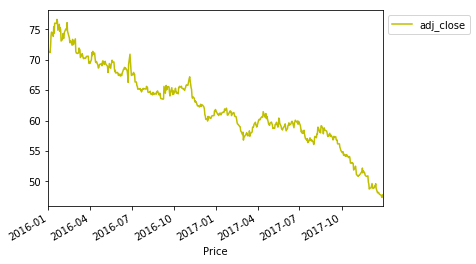

In [21]:
# Plot the three variables along with the prediction given by the MLR
Asset1.plot()
Asset2.plot()
Benchmark.plot()
prediction.plot(color='y')
plt.xlabel('Price')
plt.legend(bbox_to_anchor=(1,1), loc=2);

In [22]:
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              adj_close   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     2525.
Date:                Mon, 24 Jun 2019   Prob (F-statistic):          4.51e-262
Time:                        21:37:59   Log-Likelihood:                -1300.9
No. Observations:                 503   AIC:                             2608.
Df Residuals:                     500   BIC:                             2620.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.7056      3.406     42.490      0.000     138.014     151.397
x1             0.0365      0.004      9.644      0.000       0.029       0.044
x2            -0.0405      0.001    -35.835      0.000      -0.043      -0.038
==============================================================================
Omnibus:                       18.320   Durbin-Watson:                   0.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.335
Skew:                           0.455   Prob(JB):                     6.33e-05
Kurtosis:                       3.309   Cond. No.                     5.44e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""